In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold

import optuna
from pathlib import Path

import shap
import joblib

from typing import Optional, Dict, Tuple

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi': 150})

In [2]:
train = pd.read_csv(data_path / 'train.csv', index_col=['id'])
test = pd.read_csv(data_path / 'test.csv', index_col=['id'])

train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
print(f'Shape of training data: {train.shape}')
print(f'Shape of test data: {test.shape}')

Shape of training data: (10407, 12)
Shape of test data: (6939, 11)


## Basic EDA

All the columns are numerical and there are no missing values

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


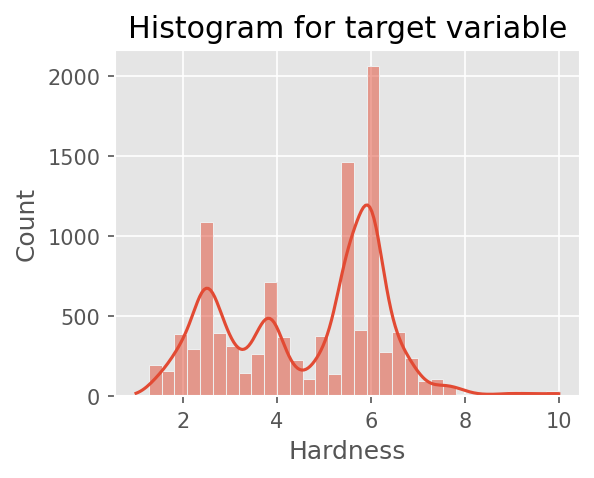

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = sns.histplot(train, x='Hardness', kde=True, ax=ax)
_ = ax.set_title('Histogram for target variable')

Here are the histogram plots of the 11 features. Clearly, there are large outlies in many of the features. For now, we will not modify the outliers.

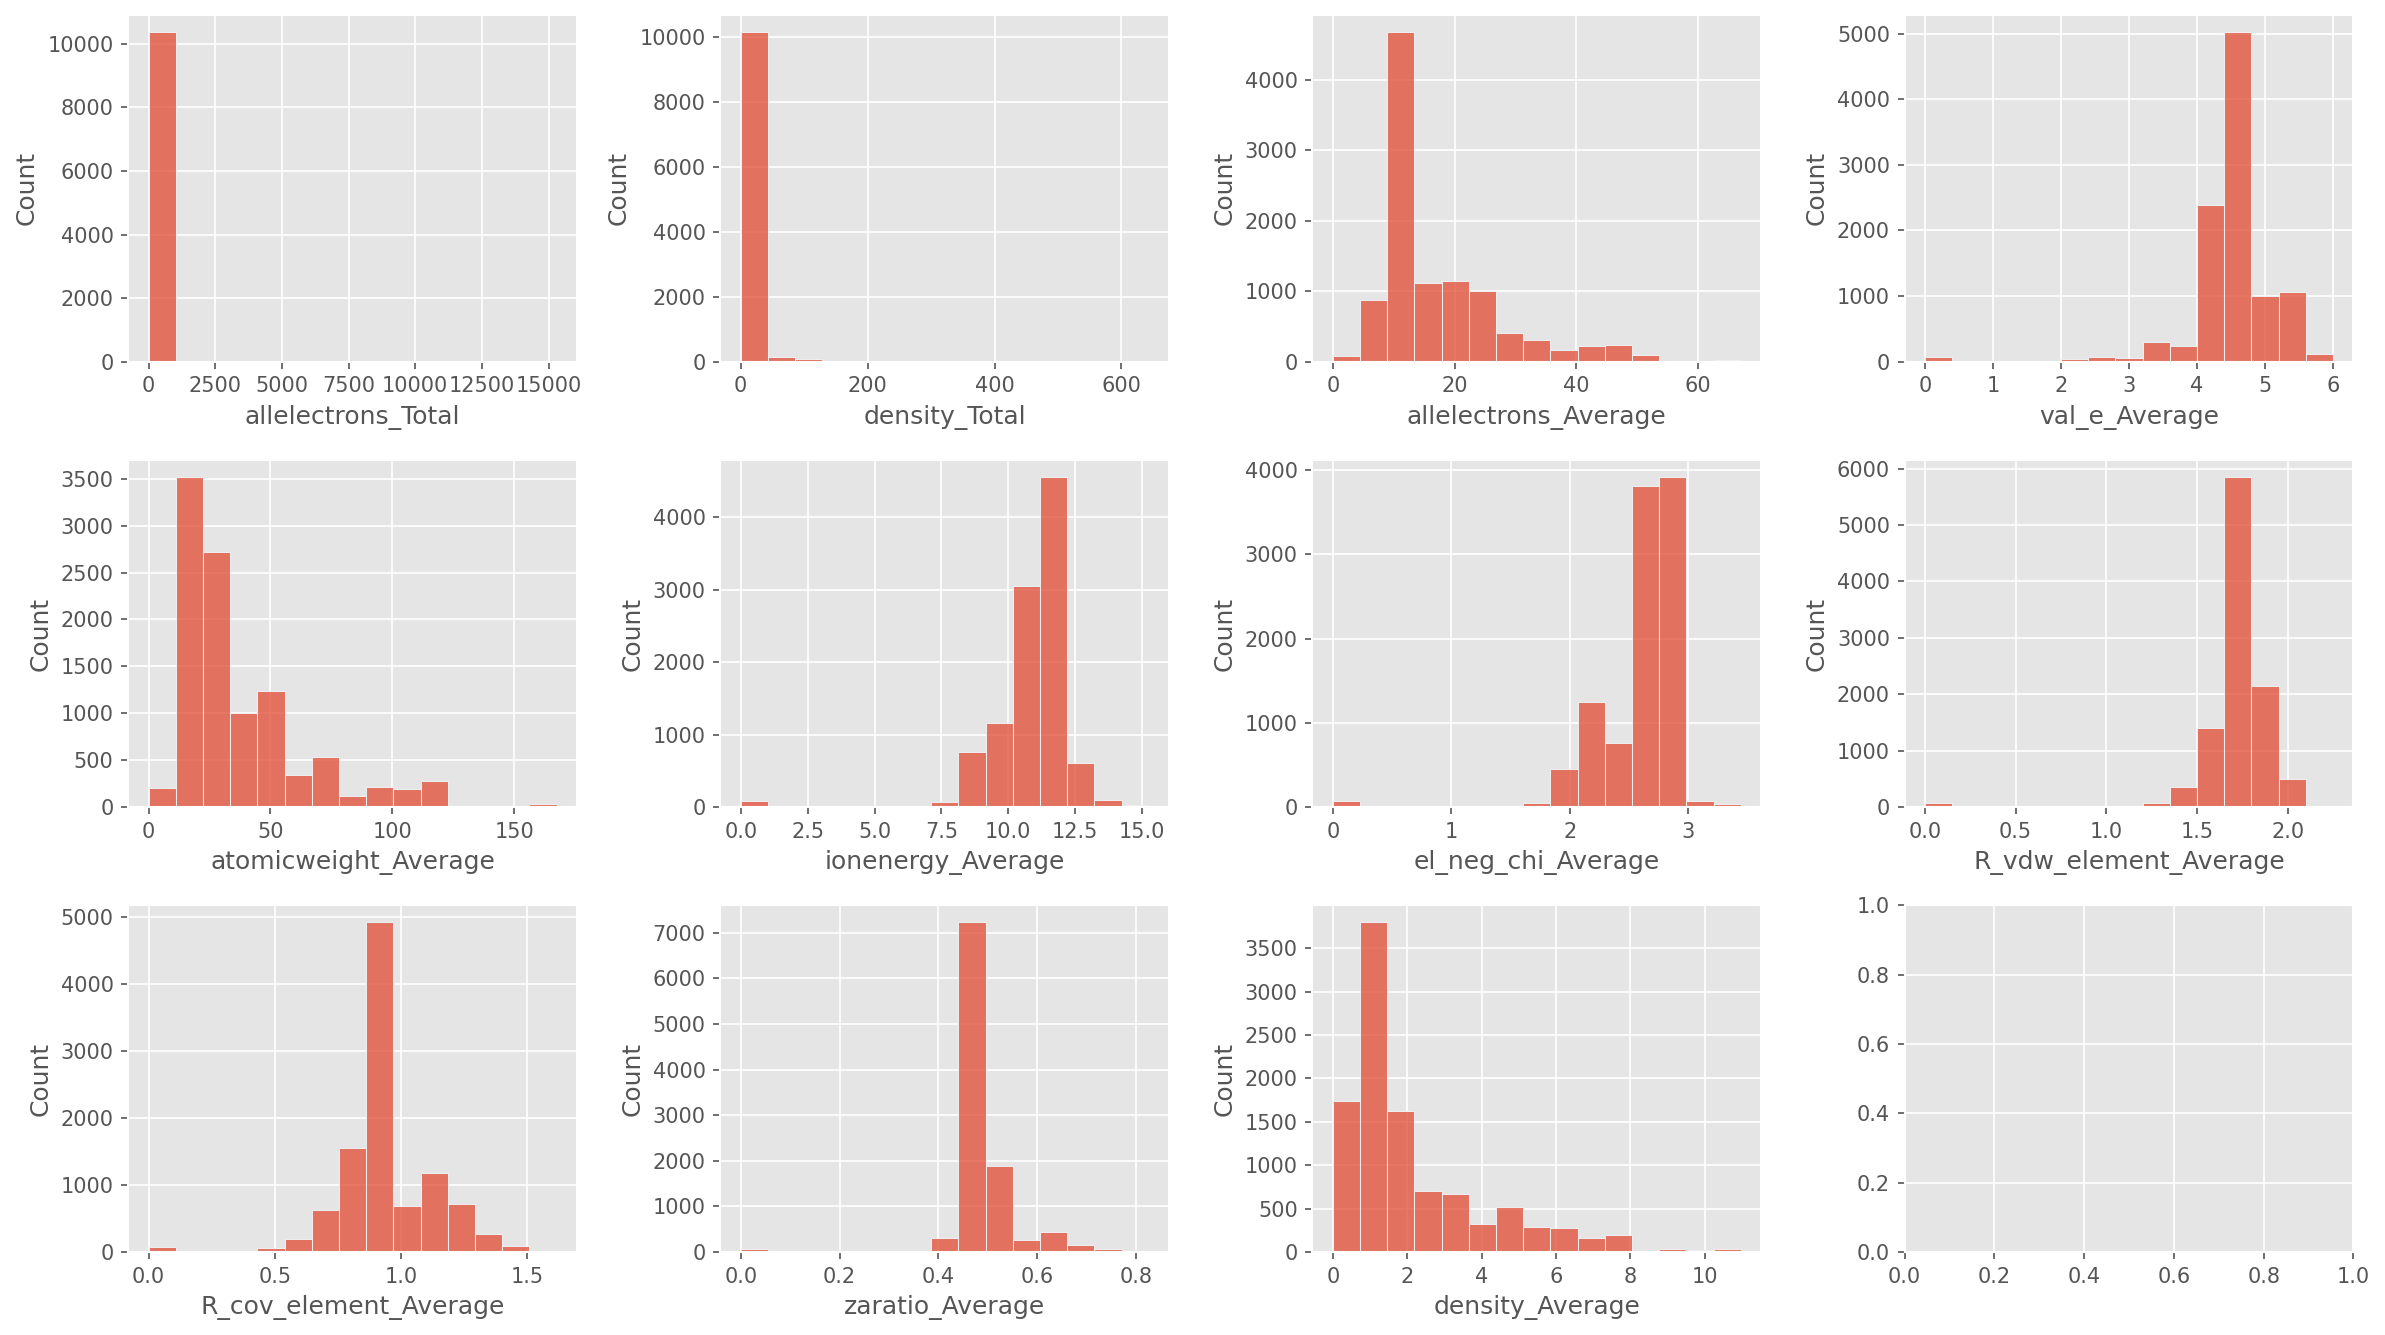

In [6]:
n_rows = 3
n_cols = 4

numerical_columns = train.drop('Hardness', axis=1).columns.tolist()
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols * i + j
        if col_idx == len(numerical_columns):
            break
        
        _ = sns.histplot(data=train, x=numerical_columns[col_idx], ax=axs[i, j], bins=15)

fig.tight_layout()

In [7]:
# prepare the dataframes
X = train.drop('Hardness', axis=1)
y = train['Hardness'].values

## Lightgbm trainining function

The function `fit_lgbm_reg_model` in the cell below trains a lightgbm regressor with L1 loss. The function also allows the specification of hyperparameters as a dictionary through the `config` argument. If `config` is not specified, default values for the hyperparameters are used.

In [8]:
def fit_lgbm_reg_model(
    X:pd.DataFrame,
    y:np.ndarray,
    config:Optional[Dict]=None,
    n_jobs:int= 4
) -> LGBMRegressor:
    '''
    Train a lightgbm regression with l1 loss
    '''
    
    model = LGBMRegressor(
        objective='regression_l1',
        n_jobs=n_jobs,
        importance_type='gain',
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    return model.fit(X, y)

## Tuning hyperparameters via Bayesian optimization

We will now optimize the hyperparameters of the lightgbm model using optuna to minimize the 5-fold CV median absolute error. 

In [9]:
import warnings
def fit_and_test_fold(config:Dict, X:pd.DataFrame, y:np.ndarray, train_index:np.ndarray, test_index:np.ndarray) -> float:
    X_train = X.iloc[train_index,:];X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = fit_lgbm_reg_model(X_train, y_train, config, n_jobs=4)
    
    # generate predictions on test data
    test_pred = model.predict(X_test)
    
    return median_absolute_error(y_test, test_pred)


def optuna_objective(trial:optuna.Trial) -> float:
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.75, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 512, log=True),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1),
        'colsample_bynode': trial.suggest_float("colsample_bynode", 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100,log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 100,log=True),
        'subsample': trial.suggest_float("subsample", 0.1, 1),
        'subsample_freq': trial.suggest_int("subsample_freq", 1, 10, log=True),
    }
    
    n_splits = 5
    cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(cv.split(X,y)):
        cv_mae[i] = fit_and_test_fold(config, X, y, train_index, test_index)
        
    # saving the individual fold holdout metrics 
    # uncomment this line if you don't want this
    trial.set_user_attr('split_mae', cv_mae)
        
    return np.mean(cv_mae)

## Final model

In [13]:
model = fit_lgbm_reg_model(X, y, study.best_params, n_jobs=4)
model.booster_.save_model(
    filename='lgbm_hardhness.txt',importance_type='gain'
)

In [14]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

CPU times: user 5min 53s, sys: 0 ns, total: 5min 53s
Wall time: 1min 32s


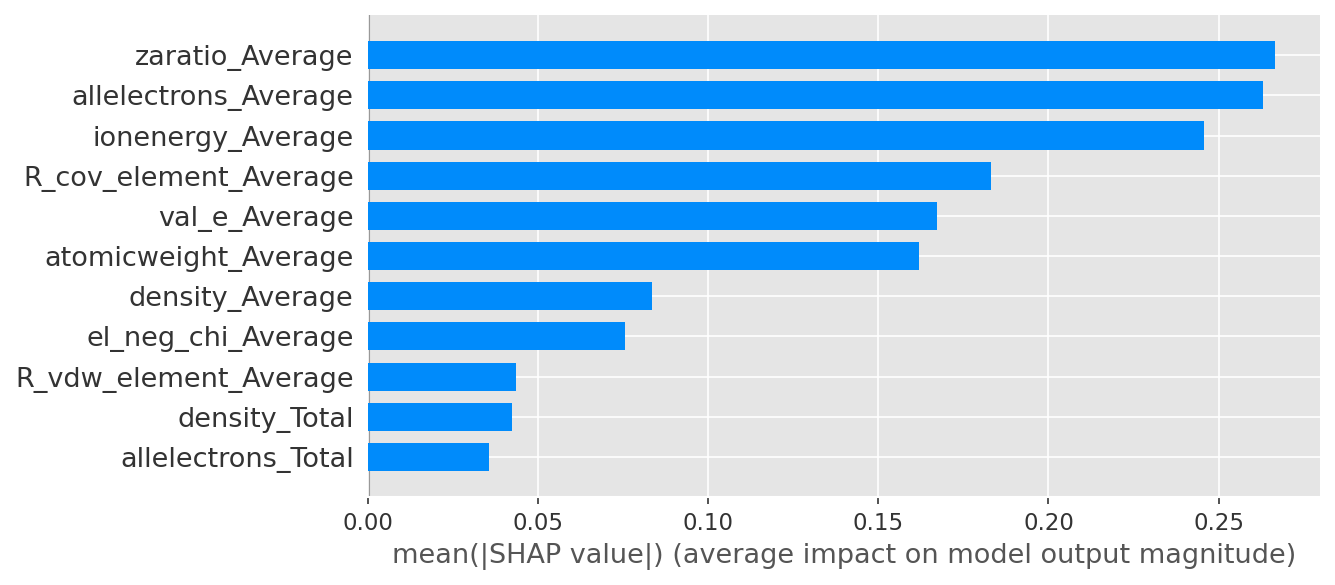

In [15]:
# Average of SHAP value magnitudes across the dataset
shap.summary_plot(
    shap_values, X, plot_type="bar",
    plot_size = (9,4)
)

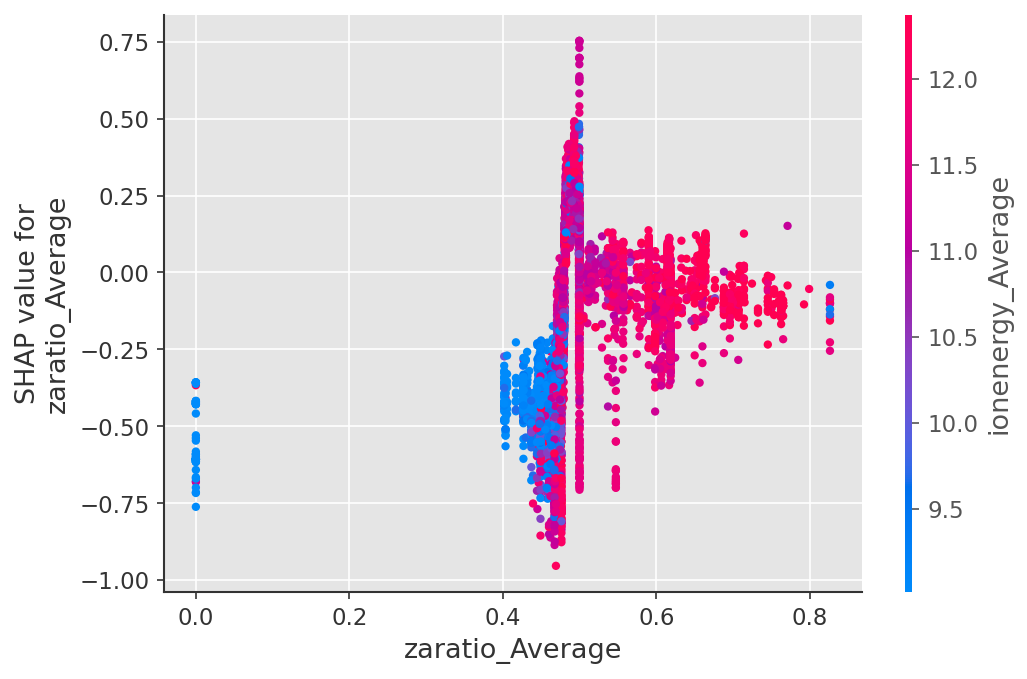

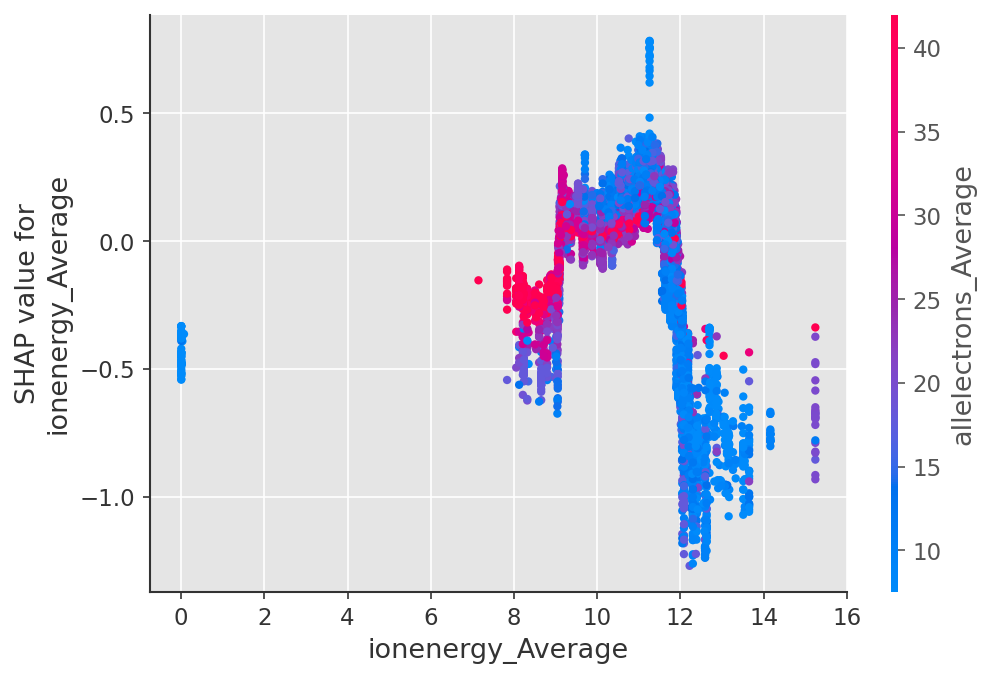

In [16]:
for col in ['zaratio_Average','ionenergy_Average']:
    shap.dependence_plot(col, shap_values, X)

## Test predictions

In [17]:
submission = pd.DataFrame({
    'id':test.index.values,
    'Hardness': model.predict(test)
})
submission.to_csv('submission.csv',index=False)
